In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from darts import TimeSeries
from darts.utils.data import tabularization as tab
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split

import utils

warnings.filterwarnings('ignore')

In [19]:
df = utils.load_data()
ts, covars_diff, covars_nodiff = utils.df2ts(df)


covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(covars_diff, should_diff=True)
covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(
    covars_nodiff, should_diff=False
)
pipeline, ts_scaled = utils.scale_ts(ts, should_diff=True)

train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))
train_ts, val_ts = ts.split_after(pd.Timestamp("2016-01-01"))

covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled)
train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(
    pd.Timestamp("2016-01-01")
)

# Model Selection

In [20]:
ts_lags = list(range(-6, 0))

lags_past_covariates = {
    "US_CPI_YOY": list(range(-3, 0)),
    "US_PERSONAL_SPENDING_PCE": list(range(-3, 0)),
    "SNP_500": list(range(-3, 0)),
    "NEWS_SENTIMENT": list(range(-3, 0)),
    "FFED": list(range(-3, 0)),
    "US_UNEMPLOYMENT_RATE": list(range(-3, 0)),
}

X_train, y_train, times, last_static_covariates_shape, sample_weight = tab.create_lagged_training_data(
    target_series=train_ts_scaled,
    past_covariates=train_covariates_scaled,
    output_chunk_length=1,
    output_chunk_shift=1,
    lags=ts_lags,
    lags_past_covariates=lags_past_covariates,
    uses_static_covariates=False,
)
X_train = X_train.squeeze()
y_train = y_train.squeeze()


X_test, y_test, times, last_static_covariates_shape, sample_weight = tab.create_lagged_training_data(
    target_series=val_ts_scaled,
    past_covariates=val_covariates_scaled,
    output_chunk_length=1,
    output_chunk_shift=1,
    lags=ts_lags,
    lags_past_covariates=lags_past_covariates,
    uses_static_covariates=False,
)
X_test = X_test.squeeze()
y_test = y_test.squeeze()

In [21]:
features_cols_names, label_cols_names = tab.create_lagged_component_names(
    ts_scaled, covariates_scaled, lags=ts_lags, lags_past_covariates=lags_past_covariates, concatenate=False
)

X_train = pd.DataFrame(X_train, columns=features_cols_names)
y_train = pd.DataFrame(y_train, columns=label_cols_names)

X_test = pd.DataFrame(X_test, columns=features_cols_names)
y_test = pd.DataFrame(y_test, columns=label_cols_names)

<Axes: >

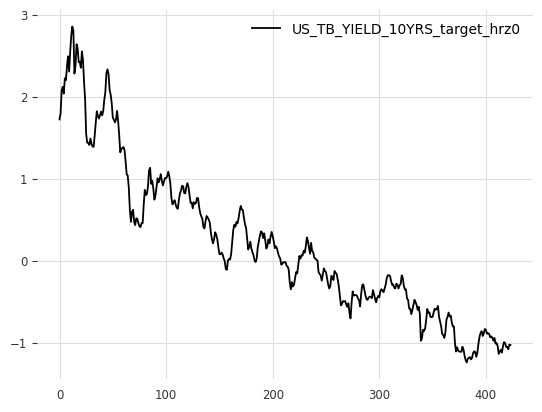

In [22]:
y_train.plot()

In [23]:
from darts.models import LinearRegressionModel


model = linear_model.LinearRegression()
timeseries_crossval = TimeSeriesSplit(n_splits=10)

sfs = SequentialFeatureSelector(
    model, k_features=(1, 10), scoring="neg_mean_squared_error", forward=True, floating=True, cv=timeseries_crossval
)
selected_features = sfs.fit(X_train, y_train)


model.fit(sfs.transform(X_train), y_train)

pred = model.predict(sfs.transform(X_test))

# diff = y_test - pred
# mse = diff.pow(2).mean()

In [33]:
# Get the model coefficients
model.coef_, sfs.k_feature_names_

(array([[ 0.07352142, -0.34065145,  1.2541513 , -0.11109673,  0.80728656]],
       dtype=float32),
 ('US_TB_YIELD_10YRS_target_lag-3',
  'US_TB_YIELD_10YRS_target_lag-2',
  'US_TB_YIELD_10YRS_target_lag-1',
  'US_CPI_YOY_pastcov_lag-2',
  'US_PERSONAL_SPENDING_PCE_pastcov_lag-2'))

In [26]:
selected_features.subsets_

{1: {'feature_idx': (5,),
  'cv_scores': array([-0.10513236, -0.01663695, -0.01600881, -0.01670706, -0.00926692,
         -0.01161456, -0.01053718, -0.01517757, -0.0115521 , -0.00479002]),
  'avg_score': -0.021742353169247507,
  'feature_names': ('US_TB_YIELD_10YRS_target_lag-1',)},
 2: {'feature_idx': (5, 12),
  'cv_scores': array([-0.09988531, -0.01631029, -0.01590369, -0.01667662, -0.00981423,
         -0.01171297, -0.00983828, -0.01474651, -0.01176274, -0.00467053]),
  'avg_score': -0.021132116625085472,
  'feature_names': ('US_TB_YIELD_10YRS_target_lag-1',
   'US_CPI_YOY_pastcov_lag-2')},
 3: {'feature_idx': (4, 5, 12),
  'cv_scores': array([-0.09655815, -0.01716417, -0.01585902, -0.01475242, -0.0097661 ,
         -0.01210503, -0.01069181, -0.01536239, -0.01115348, -0.00473843]),
  'avg_score': -0.0208151004742831,
  'feature_names': ('US_TB_YIELD_10YRS_target_lag-2',
   'US_TB_YIELD_10YRS_target_lag-1',
   'US_CPI_YOY_pastcov_lag-2')},
 4: {'feature_idx': (4, 5, 12, 13),
  'cv_sc

In [27]:
pred = pred.squeeze()
pred = TimeSeries.from_times_and_values(values=pred, times=times[0])
pred = utils.unscale_series(pred, pipeline, ts_scaled)


y_test = TimeSeries.from_times_and_values(values=y_test["US_TB_YIELD_10YRS_target_hrz0"], times=times[0])
y_test = utils.unscale_series(y_test, pipeline, ts_scaled)

<Axes: xlabel='DATE'>

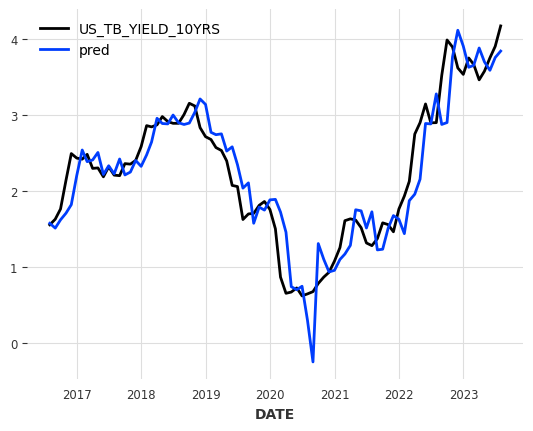

In [28]:
# pd.Series(pred.squeeze()).plot(label="pred")
# ts.drop_before(pd.Timestamp("2015/12/31")).plot()
y_test.plot()
pred.plot(label="pred")

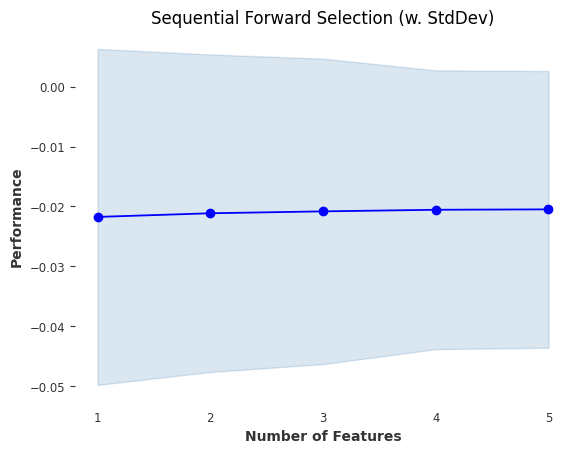

In [30]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind="std_dev")

# plt.ylim([0.8, 1])
plt.title("Sequential Forward Selection (w. StdDev)")
plt.grid()
plt.show()

In [31]:
def plot_features(features: list[str]):
    features.append("FFED_diff")
    px.line(df, x=df.index, y=features).show()

In [32]:
plot_features(['US_CPI_EXCL_FOOD_N_ENERGY_diff',
   'CANADA_CPI_diff',
   'US_TB_YIELD_1YR_diff'])

ValueError: All arguments should have the same length. The length of argument `y` is 4, whereas the length of  previously-processed arguments ['DATE'] is 524

In [ ]:
px.line(df, x=df.index, y=["FFED_diff", ]).show()